This examples provides a tool to regenerate the plots shown in https://www.overleaf.com/read/tznvqxbxdfhk.

In [1]:
import gm2              # load the library ...
from gm2 import plt, np # ... and some utilities 
%matplotlib notebook

Welcome to JupyROOT 6.12/04


/cvmfs/gm2.opensciencegrid.org/prod/external/root/v6_12_04e/Linux64bit+2.6-2.12-e15-prof/lib/ROOT.py:318: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return _orig_ihook( name, *args, **kwds )


In [2]:
runs = [3997]                # the trolley run to investigate
tr = gm2.Trolley(runs, False) # load the trolley run (load=True loads the default time, position and frequency)
_, azi, freq = tr.getBasics()
spk = [gm2.Spikes(azi[:,probe], freq[:,probe], gm2.PPM_HZ/2.) for probe in range(17)] # calculate the trolley spikes

Reading event 8730/8737 99.92%   
loop done: 100%                                    


The following cell sets the settings for the trolley probe resolution and correlation extraction

In [3]:
N = 500             # fourier expansion order. Possible range~ 500 - 700
nsigma = 3.0        # cut outliers for the correlation calculations 
th = 1.0*gm2.PPM_HZ # Hz
skip = 7            # remove the first skip points


In the following th trolley cycles without any outliers is evaluated -> sall

The residuals of these cycles are calculated (this takes a few seconds) ...

In [4]:
for probe in range(17):
    spk[probe].outl[np.isnan(spk[probe].outl)] = 1e10
s = [np.abs(spk[probe].outl) < th for probe in range(17)]
sall = s[0]
for p in range(17):
    s[p][:skip] = False
    sall = sall&s[p]
    
fr = [gm2.Fourier(azi[sall, probe], freq[sall, probe], N) for probe in range(17)]
data = [fr[probe].B(azi[sall, probe]) - freq[sall, probe] for probe in range(17)]

... and only cycles passing all test (ss) are used for....

In [5]:
show_probes = []

popt = []
ss = np.full(data[0].shape, True)
for probe in range(17):
    plt.close('all')
    popt_, _ = gm2.plotutil.histWithGauss(plt.gca(), data[probe], bins=np.arange(-100,100,2), orientation='vertical', nsigma=nsigma, alpha=1.0)
    popt.append(popt_)
    if probe in show_probes:
        plt.title("# %i" % (probe+1))
        plt.xlabel("residuals [Hz]")
        plt.plot([popt_[1] - nsigma * np.abs(popt_[2]), popt_[1] - nsigma * np.abs(popt_[2])], [0, 300], '--', color=gm2.sns.color_palette()[2])
        plt.plot([popt_[1] + nsigma * np.abs(popt_[2]), popt_[1] + nsigma * np.abs(popt_[2])], [0, 300], '--', color=gm2.sns.color_palette()[2])
        gm2.despine()
        plt.show()
    plt.clf()
    s_ = (data[probe] > popt_[1] - nsigma * np.abs(popt_[2]) )&( data[probe] < popt_[1] + nsigma * np.abs(popt_[2]) )
    ss = ss&s_


/home/scorrodi/.local/lib/python2.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


<Figure size 432x288 with 0 Axes>

... the covariance calculation.

In [6]:
phi_cov  = azi[sall, 8][ss]
data     = np.array(data)
data_cov = data[:,ss]

## Resolution as a function of position

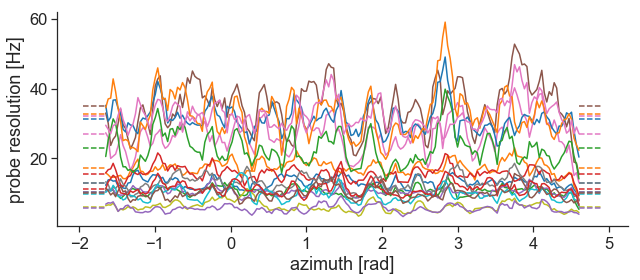

In [7]:
phi_ = []
res_ = []
cov_ = []
m = 12*4 #size of mocing window
n = m*4 # moving window steps
for i in range(n):
    l = phi_cov.min()+np.pi*2./n * i
    u = phi_cov.min()+np.pi*2./n * i + np.pi*2./m
    sss = (phi_cov > l)&(phi_cov < u)
    phi_.append((l+u)/2)
    res_.append(np.sqrt(np.diag((np.cov(data_cov[:,sss])))))
    cov_.append(np.corrcoef(data_cov[:,sss])[:,0])


fs = gm2.plotutil.figsize()

plt.figure(figsize=[fs[0]*1.5, fs[1]])
r = np.sqrt(np.diag((np.cov(data_cov))))
for i in range(17):
    plt.plot(phi_,  [res_[j][i] for j in range(len(phi_))], color=gm2.sns.color_palette()[i%10])
    plt.plot([np.max(phi_), np.max(phi_)+0.3], [r[i], r[i]], '--', color=gm2.sns.color_palette()[i%10])
    plt.plot([np.min(phi_)-0.3, np.min(phi_)], [r[i], r[i]], '--', color=gm2.sns.color_palette()[i%10])
plt.xlabel("azimuth [rad]")
plt.ylabel("probe resolution [Hz]")
gm2.despine()
plt.show()

## The Measurement's Correlation

In [7]:
plt.figure(figsize=[fs[0]*1.5, fs[1]*1.5])
ax = []
ax.append(plt.subplot2grid((17, 17), (0, 0)))
ax[-1].xaxis.set_ticklabels([])
ax[-1].yaxis.set_ticklabels([])
ax[-1].xaxis.set_ticks([])
ax[-1].yaxis.set_ticks([])
plt.title("1")
ax[-1].set_ylabel("1")

ax.append(plt.subplot2grid((17, 17), (16, 16)))
ax[-1].xaxis.set_ticklabels([])
ax[-1].yaxis.set_ticklabels([])
ax[-1].xaxis.set_ticks([])
ax[-1].yaxis.set_ticks([])

cs = gm2.sns.color_palette('Blues',10)
cs = gm2.sns.color_palette('Spectral_r',40)
cov = np.corrcoef(data_cov)

for p1 in range(0,17):
    for p2 in range(p1+1,17):
       ax.append(plt.subplot2grid((17, 17), (p1, p2)))
       ax[-1].plot(data_cov[p1,:], data_cov[p2,:], '.', markersize=2, alpha=0.1)
       ax[-1].set_xlim([-70,70])
       ax[-1].set_ylim([-70,70])
       ax[-1].xaxis.set_ticklabels([])
       ax[-1].yaxis.set_ticklabels([])
       ax[-1].xaxis.set_ticks([])
       ax[-1].yaxis.set_ticks([])
       if p1 in [0]:
           plt.title("%i" % (p2+1))
    for p2 in range(0, p1):
       ax.append(plt.subplot2grid((17, 17), (p1, p2)))
       if p2 in [0]:
          ax[-1].set_ylabel("%i" % (p1+1))
       ax[-1].xaxis.set_ticklabels([])
       ax[-1].yaxis.set_ticklabels([])
       ax[-1].xaxis.set_ticks([])
       ax[-1].yaxis.set_ticks([])
       ax[-1].text(0.5,0.5,"%.2f" % cov[p1,p2], horizontalalignment='center', verticalalignment='center', fontsize=8)
       ax[-1].set_facecolor(cs[int(np.floor(cov[p1,p2]*40)) ])

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

NameError: name 'fs' is not defined

## The Design Matrix B ##

In [8]:
pos_fp = (gm2.FP.probes.position.r, gm2.FP.probes.position.theta)
pos_tr = (gm2.TR.probes.position.r, gm2.TR.probes.position.theta)

trb  = np.array([gm2.util.multipole(pos_tr, 1,     0,    0),
                 gm2.util.multipole(pos_tr, 0, 1./45,    0),
                 gm2.util.multipole(pos_tr, 0,    0, 1./45),
                 gm2.util.multipole(pos_tr, 0,    0,     0, 1./45**2,     0),
                 gm2.util.multipole(pos_tr, 0,    0,     0,     0, 1./45**2),
                 gm2.util.multipole(pos_tr, 0,    0,     0,     0,      0, 1./45**3,     0),
                 gm2.util.multipole(pos_tr, 0,    0,     0,     0,      0,     0, 1./45**3),
                 gm2.util.multipole(pos_tr, 0,    0,     0,     0,      0,     0,     0, 1./45**4,     0),
                 gm2.util.multipole(pos_tr, 0,    0,     0,     0,      0,     0,     0,     0, 1./45**4),
                 gm2.util.multipole(pos_tr, 0,    0,     0,     0,      0,     0,     0,     0,     0, 1./45**5,     0),
                 gm2.util.multipole(pos_tr, 0,    0,     0,     0,      0,     0,     0,     0,     0,     0, 1./45**5),
                 gm2.util.multipole(pos_tr, 0,    0,     0,     0,      0,     0,     0,     0,     0,      0,     0, 1./45**6,     0),
                 gm2.util.multipole(pos_tr, 0,    0,     0,     0,      0,     0,     0,     0,     0,      0,     0,     0, 1./45**6),
                 gm2.util.multipole(pos_tr, 0,    0,     0,     0,      0,     0,     0,     0,     0,      0,     0,     0,     0, 1./45**7,     0),
                 gm2.util.multipole(pos_tr, 0,    0,     0,     0,      0,     0,     0,     0,     0,      0,     0,     0,     0,     0, 1./45**7),
                 gm2.util.multipole(pos_tr, 0,    0,     0,     0,      0,     0,     0,     0,     0,      0,     0,     0,     0,     0,     0, 1./45**8,     0),
                 gm2.util.multipole(pos_tr, 0,    0,     0,     0,      0,     0,     0,     0,     0,      0,     0,     0,     0,     0,     0,     0, 1./45**8)]).T

trb[:,12] = 0.0

## The Covariance Matrix ##

for the three models

In [9]:
e   = np.cov(data_cov)                               # cor: full correlations
e_d = np.diag(np.diag(np.cov(data_cov)))             # diag: only different resolutions, no correlations
e_a = np.diag(np.ones([17])*(275.0*gm2.PPB2HZ)**2)   # uni: uniform resolution 

## The Correlations between the fitted multipole coefficients

/home/scorrodi/.local/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in divide
  del sys.path[0]


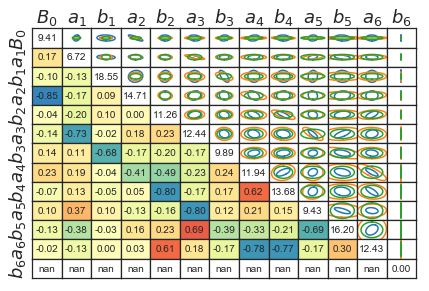

In [16]:
n_max = 6 # 0: only dipole up to 8

for n in [n_max*2+1]:
    cov   = (np.linalg.pinv(np.dot(trb[:,:n].T, np.dot(np.linalg.pinv(e),   trb[:, :n]))))
    cov_d = (np.linalg.pinv(np.dot(trb[:,:n].T, np.dot(np.linalg.pinv(e_d), trb[:, :n]))))
    cov_a = (np.linalg.pinv(np.dot(trb[:,:n].T, np.dot(np.linalg.pinv(e_a), trb[:, :n]))))

    allTypes = True
    cs = gm2.sns.color_palette('Spectral_r',40)
    plt.figure(figsize=[fs[0]*1.5, fs[1]*1.5])
    ax = []
    cov_ = cov
    cor_ = cov_ / np.sqrt(np.diag(cov_)[:,None] * np.diag(cov_))
    t = np.arange(0, 2 * np.pi, 0.01)
    for i in range(n):
        for j in range(n):
            ax.append(plt.subplot2grid((17, 17), (i, j)))
            ax[-1].xaxis.set_ticklabels([])
            ax[-1].yaxis.set_ticklabels([])
            ax[-1].xaxis.set_ticks([])
            ax[-1].yaxis.set_ticks([])
            if i == j:
                 ax[-1].text(0.5,0.5,"%.2f" % np.sqrt(cov_[i,j]), horizontalalignment='center', verticalalignment='center', fontsize=10)
                 if i in [0]:
                     ax[-1].set_title(r"$B_{0}$")
                     ax[-1].set_ylabel(r"$B_{0}$")
            if j > i:
                w, v = np.linalg.eig(cov_[[i,j]][:,[i,j]])
                xx = []
                for y in (np.array([np.cos(t), np.sin(t)]).T * np.sqrt(w)):
                     xx.append(np.dot(v, y))
                xx = np.array(xx)
                ax[-1].plot(xx[:,1], xx[:,0])
                if allTypes:
                    w_d, v_d = np.linalg.eig(cov_d[[i,j]][:,[i,j]])
                    xx_d = []
                    w_a, v_a = np.linalg.eig(cov_a[[i,j]][:,[i,j]])
                    xx_a = []
                    for y in (np.array([np.cos(t), np.sin(t)]).T * np.sqrt(w_d)):
                        xx_d.append(np.dot(v_d, y))
                    for y in (np.array([np.cos(t), np.sin(t)]).T * np.sqrt(w_a)):
                        xx_a.append(np.dot(v_a, y))
                    xx_d = np.array(xx_d)
                    xx_a = np.array(xx_a)
                    ax[-1].plot(xx_d[:,1], xx_d[:,0])
                    ax[-1].plot(xx_a[:,1], xx_a[:,0])
                ax[-1].set_xlim([-30,30])
                ax[-1].set_ylim([-30,30])
                if i in [0]:
                    if j%2 == 0:
                        ax[-1].set_title(r"$b_{%i}$" % ((j+1)//2) )
                    else:
                        ax[-1].set_title(r"$a_{%i}$" % ((j+1)//2) )
            if j < i:
                ax[-1].text(0.5,0.5,"%.2f" % cor_[i,j], horizontalalignment='center', verticalalignment='center', fontsize=10)
                if ~np.isnan(cor_[i,j]):
                    ax[-1].set_facecolor(cs[int(np.floor(cor_[i,j]*20))+20 ])
                #else:
                #    ax[-1].set_facecolor(cs[int(np.floor(cor_[i,j]*20))+20 ])
                if j in [0]:
                    if i%2 == 0:
                        ax[-1].set_ylabel(r"$b_{%i}$" % ((i+1)//2) )
                    else:
                        ax[-1].set_ylabel(r"$a_{%i}$" % ((i+1)//2) )

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

In [10]:
def f(r, phi, n, r0=45.):
    ''' Vector of multipole functions evaluated at r, phi '''
    if type(r) is not np.ndarray:
        r   = np.array([r])
        phi = np.array([phi])
    if r.shape[0] != phi.shape[0]:
        raise Exception('Dimension of r and phi have to be the samne.')
    ii = np.arange(1,n+1)
    return np.concatenate([np.ones([r.shape[0], 1]),
                           np.insert((((r[:,None]/r0)**ii) * np.sin(ii * phi[:,None])) ,np.arange(n),
                                     (((r[:,None]/r0)**ii) * np.cos(ii * phi[:,None])) , axis=1)], axis=1)

## The Field Map Resolution

/home/scorrodi/.local/lib/python2.7/site-packages/matplotlib/contour.py:1004: UserWarning: The following kwargs were not used by contour: 'inline'
  s)


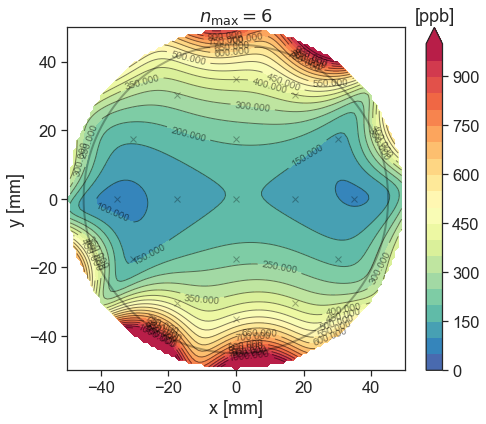

In [18]:
n_max = 6 # 0: only dipole up to 8
e_ = e # e: cor, e_d: diag, e_a: uni

for N in [n_max*2+1]:
    cov_   = (np.linalg.pinv(np.dot(trb[:,:N].T, np.dot(np.linalg.pinv(e_),  trb[:, :N]))))

    mm = 50.
    xx, yy = np.meshgrid(np.arange(-mm, mm), np.arange(-mm, mm))
    rr  = np.sqrt(xx**2 + yy**2)
    phi = np.arctan2(yy, xx)
    s2_ = np.zeros_like(xx)
    for i in range(rr.shape[0]):
        for j in range(rr[0].shape[0]):
            s2_[i,j]   = np.dot(f(rr[i,j], phi[i,j], N//2) ,np.dot(cov_, f(rr[i,j], phi[i,j], N//2).T))

    step = 50 # ppb
    if True:
        ff = gm2.plt.figure(figsize=(7, 6))
        from matplotlib.colors import ListedColormap
        s2_[rr>mm] = np.nan
        nmax = 1000
        if nmax is None:
            nmax = ((gm2.np.ceil(np.nanmax(np.sqrt(s2_)))*gm2.HZ2PPB)//step+1)*step
            nmax = np.min([nmax, 1000])
        nmin = 0
        if nmin is None:
            nmin = ((gm2.np.floor(np.nanmin(np.sqrt(s2_)))*gm2.HZ2PPB)//step)*step
        nc = int((nmax-nmin)//step)
        cmap = ListedColormap(gm2.sns.color_palette("Spectral_r", nc))
        #cmap = ListedColormap(gm2.sns.color_palette("Blues", nc))
        levels_ = gm2.np.arange(nmin, nmax+(nmax-nmin)/nc, step)
        cs = gm2.plt.contour(xx, yy, np.sqrt(s2_)*gm2.HZ2PPB,  levels=levels_, colors='k', linewidths=1.0, inline=True, alpha=0.5)
        plt.clabel(cs, inline=1, fontsize=10)
        cf = gm2.plt.contourf(xx, yy, np.sqrt(s2_)*gm2.HZ2PPB, levels=levels_, cmap=cmap, extend='max')
        cb = gm2.plt.colorbar()
        cb.ax.set_title("[ppb]")
        gm2.plt.plot(gm2.TR.probes.position.x, gm2.TR.probes.position.y, 'x', color='black', alpha=0.3)
        t = np.arange(0, np.pi*2,0.01)
        r_ = 45.
        plt.plot(r_*np.sin(t), r_*np.cos(t),color='black', alpha=0.3, linewidth=2)

        gm2.plt.xlim([-mm, mm])
        gm2.plt.ylim([-mm, mm])
        gm2.plt.xlabel("x [mm]")
        gm2.plt.ylabel("y [mm]")
        plt.title(r"$n_{\rm{max}}=%i$" % (N//2))
        gm2.plt.tight_layout()
        plt.show()


Load the data, interpolate between data points and evaluate the fit...

In [11]:
e_ = e # e: cor, e_d: diag, e_a: uni


calib = tr.getCalibration()[0] #np.zeros([17])
freqAt_sall = [gm2.util.interp1d(azi[sall,probe], freq[sall,probe] + calib[probe], fill_value='extrapolate') for probe in range(17)]
w_interpol_sall  = np.array([freqAt_sall[probe](azi[:,8]) for probe in range(17)]).T
w = w_interpol_sall
nev = w.shape[0]

m = []
res   = np.zeros([9, nev, 17], dtype=float)
chi2   = np.zeros([9, nev], dtype='float')

peff= np.zeros([9,3],dtype=float)

for n in range(1,18,2):
    print "\r n=", n,
    M   = np.dot((np.linalg.pinv(np.dot(trb[:,:n].T, np.dot(np.linalg.pinv(e_), trb[:, :n])))), np.dot(trb[:,:n].T , np.linalg.pinv(e)))
    peff[(n//2),0] = np.trace(np.dot(trb[:, :n], M))

    m_   = np.zeros([nev, n], dtype=float)

    for ev in range(nev):
        m_[ev,:]   = np.dot(M, w[ev,:])
        res[(n//2), ev,:]   = (w[ev,:] - np.dot(trb[:, :n], m_[ev,  :]))
        chi2[(n//2), ev]    = np.dot(res[(n//2),   ev,:].T, np.dot(np.linalg.pinv(e), res[(n//2), ev,:]))
    m.append(m_)

/home/scorrodi/.local/lib/python2.7/site-packages/scipy/interpolate/interpolate.py:610: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/scorrodi/.local/lib/python2.7/site-packages/scipy/interpolate/interpolate.py:613: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 n= 17       


## Chi2 Distributions

<IPython.core.display.Javascript object>


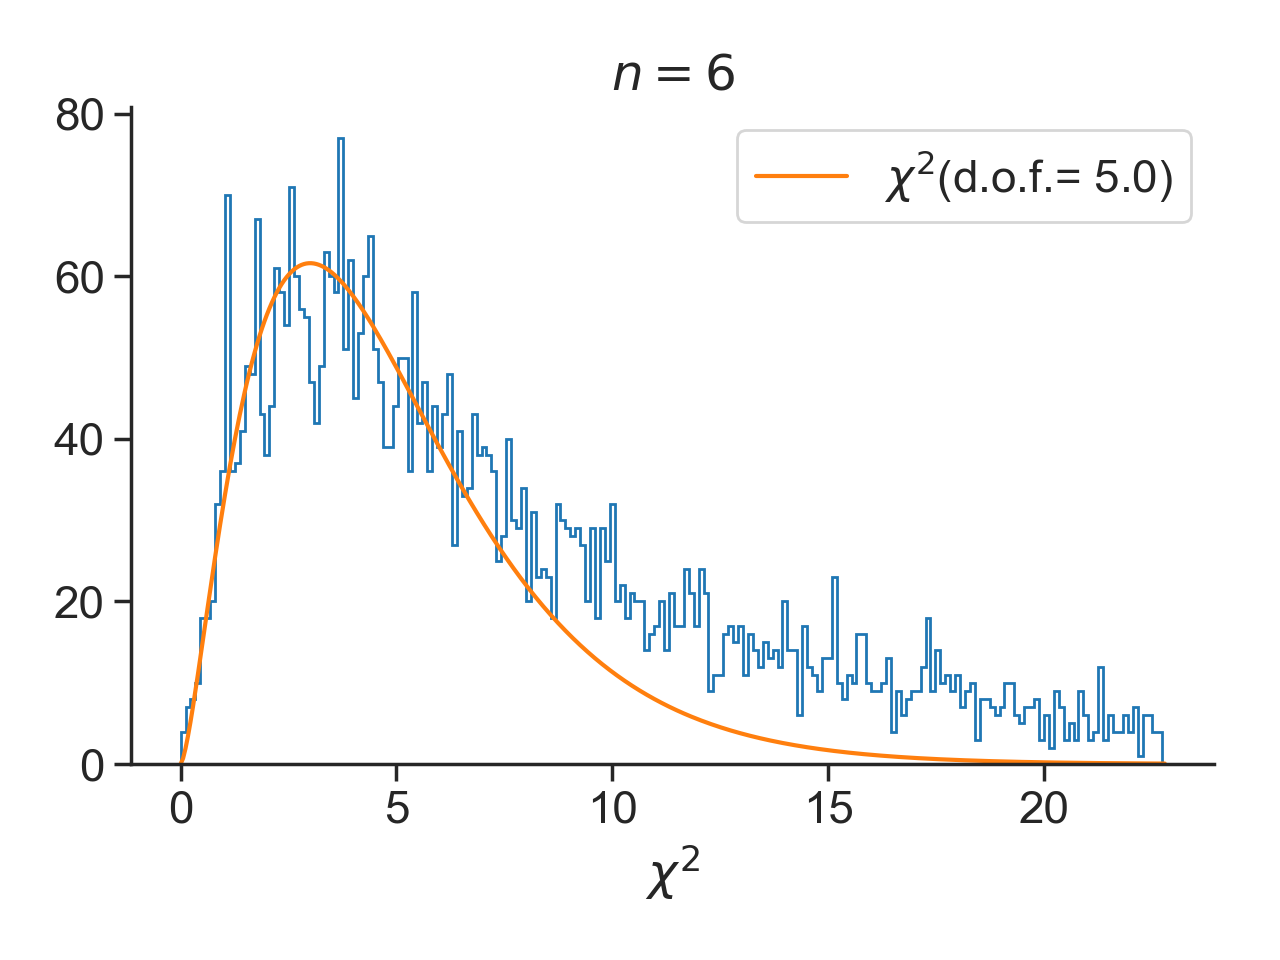

In [16]:
%matplotlib notebook
n = 6

import scipy.stats as stats

nlim = 200
if True:
    lim = np.nanmean(chi2[n,:])
    v  , _, _ = plt.hist(chi2[n,sall][~np.isnan(chi2[n,sall])],   bins=np.arange(0,lim, lim/nlim), histtype='step')
    tt = np.arange(0, lim, lim/nlim/2.)
    chi2_ = stats.chi2.pdf(tt,17.-peff[n,0])
    plt.plot(tt, chi2_/chi2_.max()*v.max()*0.8, '-', label=r"$\chi^2$(d.o.f.= %.1f)" % (17.-peff[n,0]))
    plt.xlabel(r"$\chi^{2}$")
    plt.title(r"$n=%i$" % (n))
    plt.legend()
    gm2.despine()
    plt.show()


In [17]:
%matplotlib notebook
n = 6
plt.subplot(3,1,1)
plt.plot(azi[sall,8], chi2[n,sall],  '.', markersize=2, alpha=1)
plt.ylabel("$\chi^2$")
plt.title(r"$n=%i$" % n)
plt.subplot(3,1,2)
plt.plot(azi[sall,8], res[n,sall],  '.', markersize=2, alpha=1)
plt.ylabel("residuals [Hz]")
#plt.plot(azi[sall,8], chi2_d[n,sall],'.', markersize=2, alpha=1, label="diag")
#plt.plot(azi[sall,8], chi2_a[n,sall],'.', markersize=2, alpha=1, label="uniform")
plt.xlabel("azimuth [rad]")

gm2.despine()
plt.show()

IOError: [Errno 24] Too many open files: '/home/scorrodi/.local/lib/python2.7/site-packages/matplotlib/backends/web_backend/js/mpl.js'

## The Residuals

<IPython.core.display.Javascript object>


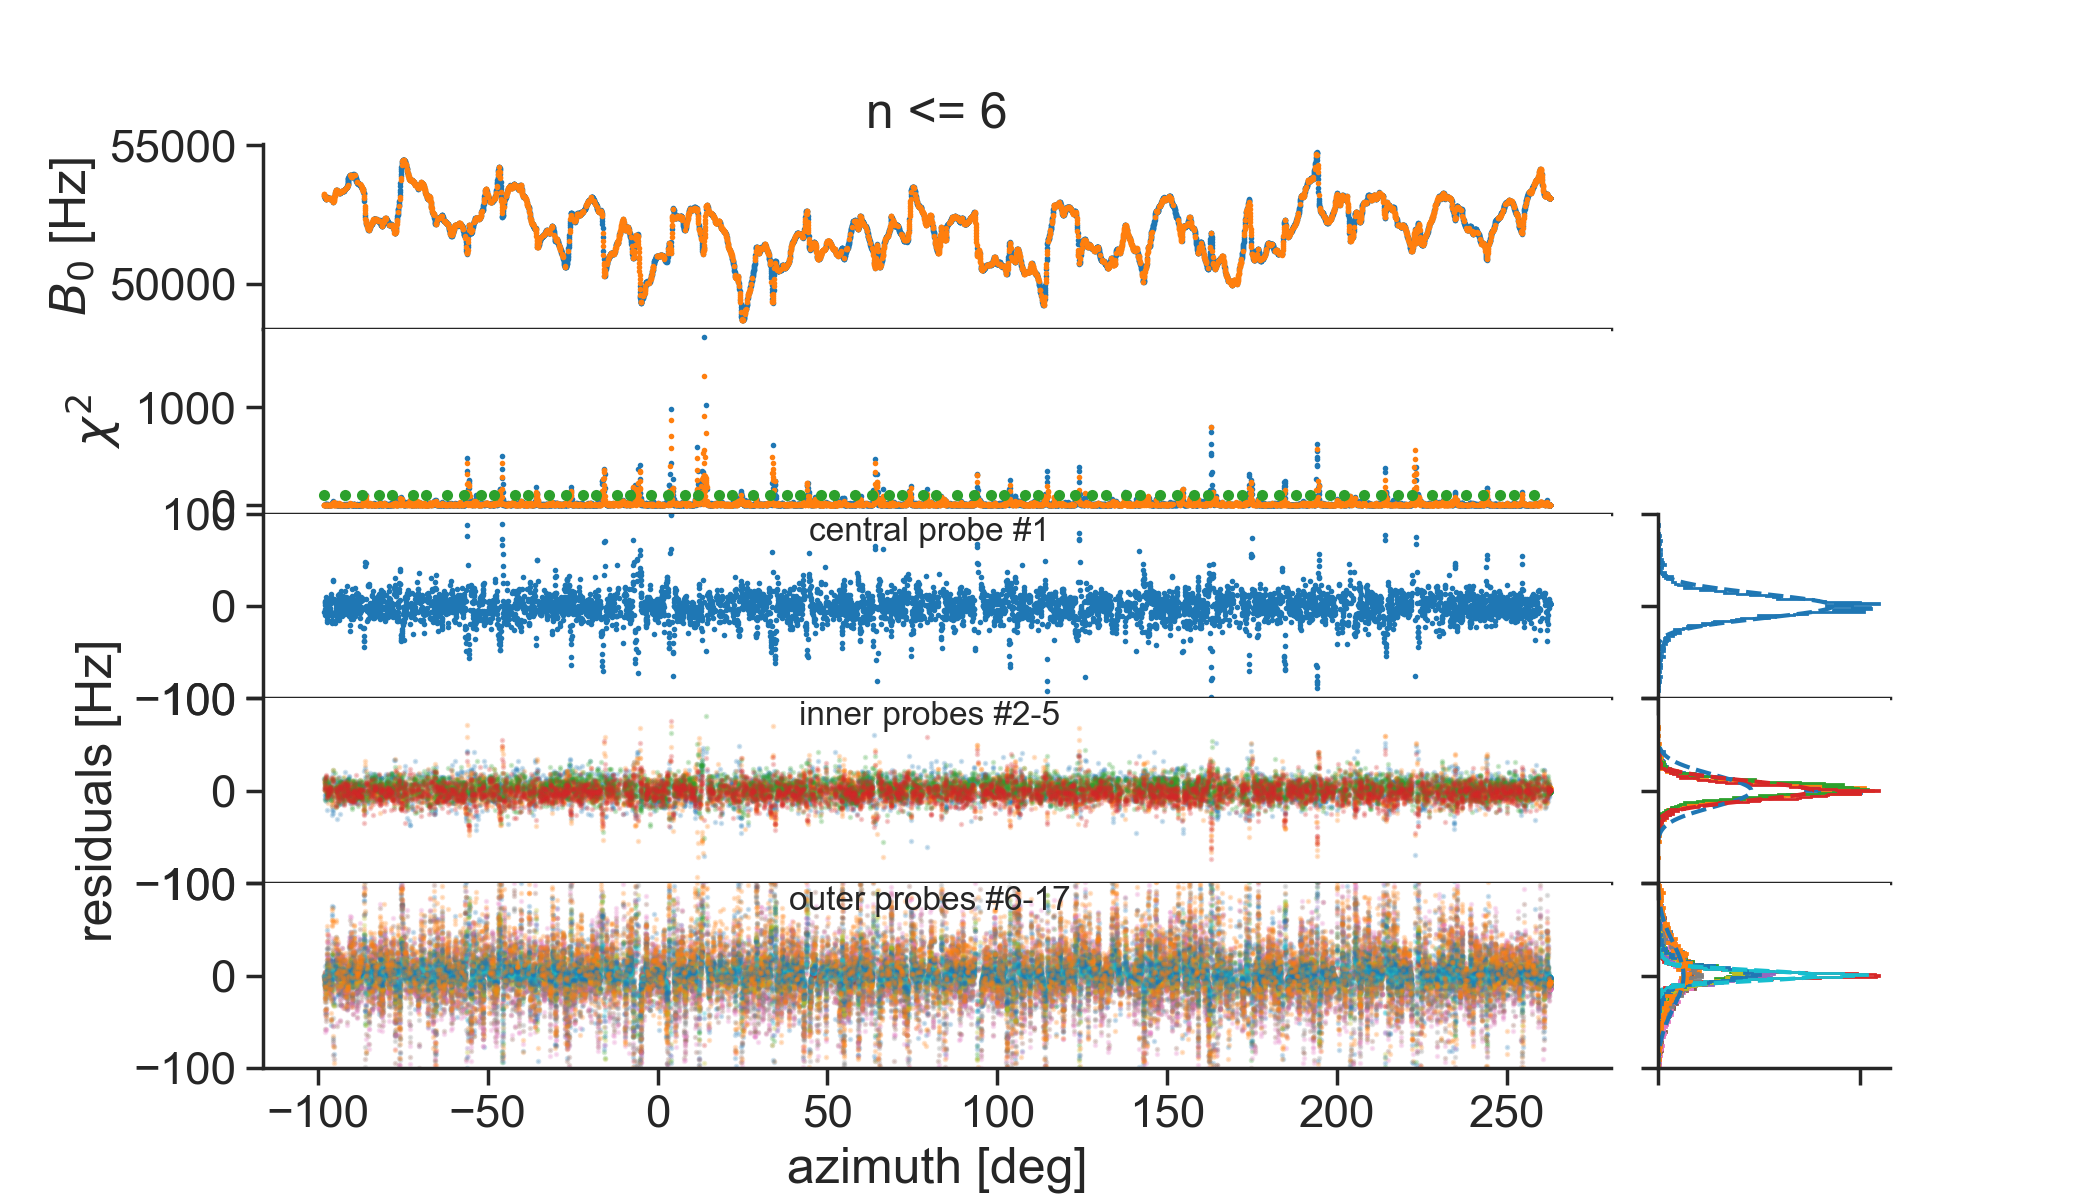

In [30]:
%matplotlib notebook
n_max = 6

azimuth = gm2.FP.stations.azimuth
azimuth[azimuth < tr.azi[sall,8].min()] += 2*np.pi

''' plot residuals '''
fp = True
res_  = res
chi2_ = chi2
m_    = m
suffix_ = ""
lims = [100,100,100]
for n in [n_max]:
    plt.figure(figsize=[fs[0]*1.75,fs[1]*1.5])
    ax1_1 = plt.subplot2grid((5, 6), (0, 0), colspan=5)
    ax2_1 = plt.subplot2grid((5, 6), (1, 0), colspan=5, sharex=ax1_1)
    ax3_1 = plt.subplot2grid((5, 6), (2, 0), colspan=5, sharex=ax1_1)
    ax4_1 = plt.subplot2grid((5, 6), (3, 0), colspan=5, sharex=ax1_1)
    ax5_1 = plt.subplot2grid((5, 6), (4, 0), colspan=5, sharex=ax1_1)
    ax3_2 = plt.subplot2grid((5, 6), (2, 5), sharey=ax3_1)
    ax4_2 = plt.subplot2grid((5, 6), (3, 5), sharey=ax4_1)
    ax5_2 = plt.subplot2grid((5, 6), (4, 5), sharey=ax5_1)
    ax1_1.set_title("n <= %i" % (n))
    ax1_1.plot(tr.azi[sall,8]/np.pi*180., m_[n][sall,0],  '.', markersize=2, alpha=1)
    ax1_1.plot(tr.azi[~sall,8]/np.pi*180., m_[n][~sall,0],  '.', markersize=2, alpha=1)
    ax1_1.set_ylabel("$B_0$ [Hz]")
    ax2_1.plot(tr.azi[sall,8]/np.pi*180., chi2_[n,sall],  '.', markersize=2, alpha=1)
    ax2_1.plot(tr.azi[~sall,8]/np.pi*180., chi2_[n,~sall],  '.', markersize=2, alpha=1)
    if fp:
        ax2_1.plot(azimuth/np.pi*180., np.ones_like(azimuth)*100.,'.')
    ax2_1.set_ylabel("$\chi^2$")
    ax3_1.text(80, 80, "central probe #1", horizontalalignment='center', verticalalignment='center', fontsize=12)
    ax3_1.plot(tr.azi[sall,8]/np.pi*180., res_[n,sall,0], '.', markersize=2)
    ax3_1.set_ylim([-lims[0],lims[0]])
    ax4_1.text(80, 80, "inner probes #2-5", horizontalalignment='center', verticalalignment='center', fontsize=12)
    ax4_1.plot(tr.azi[sall,8]/np.pi*180, (res_[n,sall,1:5]), '.', markersize=2, alpha=0.2)
    ax4_1.set_ylabel("residuals [Hz]")
    ax4_1.set_ylim([-lims[1],lims[1]])
    ax5_1.text(80, 80, "outer probes #6-17", horizontalalignment='center', verticalalignment='center', fontsize=12)
    ax5_1.plot(tr.azi[sall,0]/np.pi*180, (res_[n,sall,5:17]), '.', markersize=2, alpha=0.2)
    ax5_1.set_ylim([-lims[2], lims[2]])
    ax5_1.set_xlabel("azimuth [deg]")
    ax3_2.set_xticklabels("")
    ax4_2.set_xticklabels("")
    ax5_2.set_xticklabels("")
    plt.setp(ax3_2.get_yticklabels(), visible=False)
    plt.setp(ax4_2.get_yticklabels(), visible=False)
    plt.setp(ax5_2.get_yticklabels(), visible=False)
    v,_,_,=ax3_2.hist((res_[n,sall,0]), bins=np.arange(-lims[0],lims[0],1), histtype='step', orientation='horizontal')
    tt = np.arange(-lims[0], lims[0], 1)
    ax3_2.plot(gm2.util.gauss(tt, res_[n,sall,0].shape[0], 0.0, np.sqrt(e[0,0])), tt, '--', color=gm2.sns.color_palette()[0] )
    for i in range(1,5):
         ax4_2.hist((res_[n,sall,i]), bins=np.arange(-lims[1],lims[1],1), histtype='step', orientation='horizontal')
    ax4_2.plot(gm2.util.gauss(tt, res_[n,sall,1].shape[0], 0.0, np.sqrt(e[1,1])), tt, '--', color=gm2.sns.color_palette()[0] )
    ax4_2.plot(gm2.util.gauss(tt, res_[n,sall,4].shape[0], 0.0, np.sqrt(e[4,4])), tt, '--', color=gm2.sns.color_palette()[3] )
    for i in range(5,17):
         ax5_2.hist((res_[n,sall,i]), bins=np.arange(-lims[2],lims[2],1), histtype='step', orientation='horizontal')

    ax5_2.plot(gm2.util.gauss(tt, res_[n,sall,5].shape[0], 0.0, np.sqrt(e[5,5])), tt, '--', color=gm2.sns.color_palette()[0] )
    ax5_2.plot(gm2.util.gauss(tt, res_[n,sall,14].shape[0], 0.0, np.sqrt(e[14,14])), tt, '--', color=gm2.sns.color_palette()[14-5] )
    plt.subplots_adjust(hspace=0)
    gm2.sns.despine()
    #plt.savefig("plots/residuals_n%i_%s.png" % (n, suffix_))
    #plt.savefig("plots/residuals_n%i_%s.pdf" % (n, suffix_))
    plt.show()

## Residuals II

In [1]:
lims = 100.0
plt.figure(figsize=[fs[0]*1.75,fs[1]*1.5])
ax = []
tt = np.arange(-lims, lims, 1)
res_ = res
suffix_ = ""
for p in range(17):
    for n in range(9):
        ax.append(plt.subplot2grid((9, 17), (n,  p)))
        ax[-1].hist(res_[n,sall,p], bins=np.arange(-lims, lims,1), histtype='step', orientation='vertical')
        ax[-1].plot(tt, gm2.util.gauss(tt, res[n,sall,p].shape[0], 0.0, np.sqrt(e[p,p])),  '--' )
        #ax[-1].hist(res_d[n,sall,p], bins=np.arange(-lims, lims,1), histtype='step', orientation='vertical')
        #ax[-1].hist(res_a[n,sall,p], bins=np.arange(-lims, lims,1), histtype='step', orientation='vertical')
        ax[-1].set_xlim([-lims, lims])
        if n < 9:
             plt.setp(ax[-1].get_xticklabels(), visible=False)
        plt.setp(ax[-1].get_yticklabels(), visible=False)
        ax[-1].set_yticks([])
        if n in [0]:
            if p in [8]:
                 ax[-1].set_title("probe\n%i" % (p+1))
            else:
                 ax[-1].set_title("\n%i" % (p+1))
        if p in [0]:
            if n in [4]:
                ax[-1].set_ylabel("$n_{{max}}$ \n $%i$" % n)
            else:
                ax[-1].set_ylabel("\n$%i$" % n)

plt.subplots_adjust(hspace=0, wspace=0)
plt.show()


NameError: name 'plt' is not defined